# Trajectory Optimization for a planar walker

## Start meshcat visualizer

Open the visualizer by clicking on the url in the output of this cell.

In [1]:
from pydrake.all import FindResourceOrThrow, StartMeshcat, MeshcatVisualizer
import matplotlib.pyplot as plt
import numpy as np
import time
from pydrake.math import RigidTransform
from pydrake.all import (
    DiagramBuilder, Simulator, FindResourceOrThrow, MultibodyPlant, PiecewisePolynomial, SceneGraph,
    Parser, MultibodyPositionToGeometryPose, TrajectorySource, Demultiplexer, ConstantVectorSource
)
import importlib
from direct_col_dev import find_throwing_trajectory

meshcat = StartMeshcat()


INFO:drake:Meshcat listening for connections at http://localhost:7000


In [2]:
from dataclasses import dataclass
from pydrake.multibody.tree import Frame

@dataclass
class PointOnFrame:
    frame: Frame
    pt: np.ndarray

def get_foot_pos(context, plant):
    contact_points = {
    0: PointOnFrame(
        plant.GetBodyByName("left_lower_leg").body_frame(),
        np.array([0, 0, -0.5])
    ),
    1: PointOnFrame(
        plant.GetBodyByName("right_lower_leg").body_frame(),
        np.array([0, 0, -0.5])
    )
    }
    ft = np.zeros((3,2))
    i =0
    for fsm in [0,1]:
        pt_to_track = contact_points[fsm]
        ft[:,i] = plant.CalcPointsPositions(context, pt_to_track.frame,
                                        pt_to_track.pt, plant.world_frame()).ravel()
        i+=1
    return ft    


## Run trajectory optimization to find the optimal trajectory

In [3]:
N = 10
initial_state = np.zeros(14)
q = np.zeros((7,))
# q[0] = 0; q[1] = 0.6
# theta = -np.arccos(q[1])
# q[3] = theta; q[4] = -2 * theta
# q[5] = theta;   q[6] = -2 * theta


q = np.zeros((7,))
q[0] = 0; q[1] = 1
theta = -np.arccos(q[1])
q[3] = theta; q[4] = -2 * theta
q[5] = theta;   q[6] = -2 * theta
initial_state[:7] = q

final_state = initial_state
# final_configuration = np.array([np.pi, 0])
tf = 1/2
x_traj, u_traj, prog,  _, _ = find_throwing_trajectory(N, initial_state, 0.2, tf=tf, jumpheight_tol=5e-2)


Starting the solve
optimal cost:  409613.903252029
x_sol:  [[ 0.0000e+00  1.0000e+00  0.0000e+00 -0.0000e+00  0.0000e+00  0.0000e+00
  -0.0000e+00  0.0000e+00 -0.0000e+00  0.0000e+00 -0.0000e+00 -0.0000e+00
   0.0000e+00  0.0000e+00]
 [-0.0000e+00  1.0000e+00  0.0000e+00 -1.0000e-02  3.0000e-02 -7.0000e-02
   1.4000e-01  1.0000e-02  3.0000e-02  4.0000e-02  4.3000e-01 -3.6900e+00
  -4.2000e-01  6.5000e-01]
 [ 0.0000e+00  1.0000e+00  0.0000e+00 -6.0000e-02  1.2000e-01 -3.0000e-02
   6.0000e-02 -0.0000e+00  2.5000e-01  6.0000e-02 -2.6500e+00  6.3100e+00
   3.0000e-02 -2.0000e-01]
 [ 0.0000e+00  1.0000e+00 -0.0000e+00 -2.7000e-01  5.3000e-01 -1.0000e-01
   2.1000e-01 -3.0000e-02 -3.1000e-01 -1.0000e-02 -4.2400e+00  7.5900e+00
  -1.3500e+00  4.0800e+00]
 [ 0.0000e+00  1.0000e+00  0.0000e+00 -3.6000e-01  6.3000e-01 -1.5000e-01
   2.4000e-01  5.0000e-02 -7.6000e-01  2.3000e-01  3.2500e+00 -5.7000e+00
  -6.1000e-01 -6.7200e+00]
 [ 1.0000e-02  9.6000e-01 -0.0000e+00 -8.0000e-02  4.0000e-02 -3.7

## Visualize the optimal trajectory

This will animate the optimal trajectory in the meshcat window (see above)

In [4]:
from pydrake.all import AddMultibodyPlantSceneGraph, HalfSpace, CoulombFriction, MeshcatVisualizerParams, ConstantValueSource
# Create a MultibodyPlant for the arm
file_name = "/home/dhruv/Hop-Skip-and-Jump/models/planar_walker.urdf"

builder = DiagramBuilder()

#### Designing our world ####
# Add a planar walker to the simulation
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.0005)
#Half space means a plane -> Ground Plane in particular
X_WG = HalfSpace.MakePose(np.array([0,0, 1]), np.zeros(3,))
plant.RegisterCollisionGeometry(plant.world_body(), X_WG, HalfSpace(), 
    "collision", CoulombFriction(1.0, 1.0))

#Make the plant
parser = Parser(plant)
parser.AddModels(file_name)
plant.WeldFrames(plant.world_frame(),
    plant.GetBodyByName("base").body_frame(),
    RigidTransform.Identity())
plant.Finalize()

n_q = plant.num_positions()
n_v = plant.num_velocities()
n_u = plant.num_actuators()

# x_traj_mod = np.zeros((n))
x_traj_source = builder.AddSystem(TrajectorySource(x_traj))
u_traj_source = builder.AddSystem(TrajectorySource(u_traj))

demux = builder.AddSystem(Demultiplexer(np.array([n_q, n_v])))
to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(plant))
zero_inputs = builder.AddSystem(ConstantVectorSource(np.zeros(n_u)))

builder.Connect(zero_inputs.get_output_port(), plant.get_actuation_input_port())
builder.Connect(x_traj_source.get_output_port(), demux.get_input_port())
builder.Connect(demux.get_output_port(0), to_pose.get_input_port())
# builder.Connect(to_pose.get_output_port(), scene_graph.get_source_pose_port(plant.get_source_id()))

# MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

vis_params = MeshcatVisualizerParams(publish_period=0.0005)
MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat, params=vis_params)



diagram = builder.Build()
diagram.set_name("diagram")

simulator = Simulator(diagram)
simulator.Initialize()
plant_context = diagram.GetMutableSubsystemContext(plant, simulator.get_mutable_context())

plant.SetPositions(plant_context, q)



  
# simulator.set_target_realtime_rate(.1)
# simulator.AdvanceTo(1);
timesteps = np.linspace(0, tf, 1000)
com_pos_list = []
vel_list = []
for t in timesteps:
  x = x_traj.vector_values([t])
  u = np.linalg.norm(u_traj.vector_values([t]))
  plant.SetPositionsAndVelocities(plant_context, x)
  com_pos = plant.CalcCenterOfMassPositionInWorld(plant_context).ravel()
  com_pos_list.append(com_pos)
#   ft = np.min(get_foot_pos(plant_context, plant)[-1,:])
#   vel_list.append(ft)

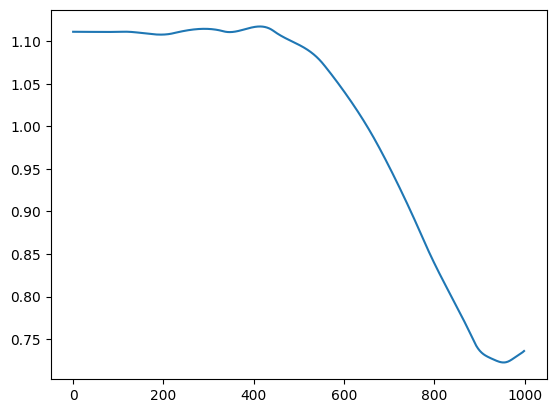

In [5]:
# fig = plt.figure()
# plt.plot(timesteps, com_pos_list[:][2])
# plt.plot(timesteps,vel_list)
# plt.show()

# np.save('com.npy', np.array(com_pos_list))
plt.plot(np.array(com_pos_list)[:,2])

In [6]:
TrajectorySource(x_traj)

from pydrake.all import LeafSystem, AbstractValue
class tmp(LeafSystem):
    def __init__(self, x_traj):
        super().__init__()
        self.com_traj_output_port_index = self.DeclareAbstractOutputPort(
            "com_traj", 
            lambda: AbstractValue.Make(PiecewisePolynomial()),
            self.CalcComTraj
        ).get_index()
        self.x_traj = x_traj
    
    def CalcComTraj(self, context, output):
        output.set_value(self.x_traj)




In [9]:
#Start the meshcat server
builder = DiagramBuilder()

#### Designing our world ####
# Add a planar walker to the simulation
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.0005)
#Half space means a plane -> Ground Plane in particular
X_WG = HalfSpace.MakePose(np.array([0,0, 1]), np.zeros(3,))
plant.RegisterCollisionGeometry(plant.world_body(), X_WG, HalfSpace(), 
    "collision", CoulombFriction(1.0, 1.0))

#Make the plant
parser = Parser(plant)
parser.AddModels("../models/planar_walker.urdf")
plant.WeldFrames(plant.world_frame(),
    plant.GetBodyByName("base").body_frame(),
    RigidTransform.Identity())
plant.Finalize()
import osc_modified
import osc_tracking_objective
importlib.reload(osc_modified)
importlib.reload(osc_tracking_objective)
from osc_modified import OperationalSpaceWalkingController
#### Designing the controller ####
zdes = 1.5 #desired Z height in meters
z_height_desired = builder.AddSystem(ConstantVectorSource(np.array([zdes])))
base_traj_src = builder.AddSystem(
    ConstantValueSource(AbstractValue.Make(PiecewisePolynomial(np.zeros(1,))))
)
x_traj_source = builder.AddSystem(tmp(x_traj))
# preflight_planner = builder.AddSystem(dircol())
osc = builder.AddSystem(OperationalSpaceWalkingController(0))

#DIRCOL OUT -> OSC IN
builder.Connect(x_traj_source.get_output_port(), osc.get_traj_input_port("com_traj"))
builder.Connect(base_traj_src.get_output_port(), osc.get_traj_input_port("base_joint_traj"))
builder.Connect(plant.get_state_output_port(), osc.get_state_input_port()) 
builder.Connect(osc.torque_output_port, plant.get_actuation_input_port())
from pydrake.all import LogVectorOutput
logger = LogVectorOutput(osc.GetOutputPort("metrics"),builder, publish_period=0.01)

# Add the visualizer
vis_params = MeshcatVisualizerParams(publish_period=0.005)
MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat, params=vis_params)

#simulate
diagram = builder.Build()





sim_time = tf
simulator = Simulator(diagram)
simulator.Initialize(); simulator.set_target_realtime_rate(0.1)

# State Description: q = [x, z, planar_roty, left_hip, left_knee, right_hip, right_knee]
plant_context = diagram.GetMutableSubsystemContext(plant, simulator.get_mutable_context())


# initial_state= np.zeros((  14,))
# q = np.zeros((7,))
q = np.zeros((7,))
q[0] = 0; q[1] = 1
theta = -np.arccos(q[1])
q[3] = theta; q[4] = -2 * theta
q[5] = theta;   q[6] = -2 * theta
initial_state[:7] = q

final_state = initial_state

plant.SetPositions(plant_context, q)

# Simulate the robot
simulator.AdvanceTo(tf+0.4)

## Logs and Plots ##


chel
-1.1
-1.0
-1.0
-1.0
-1.0
-0.9
-0.9
-0.9
-0.8
-0.8
-0.8
-0.8
-0.7
-0.7
-0.7
-0.6
-0.6
-0.6
-0.6
-0.5
-0.5
-0.5
-0.4
-0.4
-0.4
-0.3
-0.3
-0.3
-0.3
-0.2
-0.2
-0.2
-0.1
-0.1
-0.1
-0.1
-0.0
-0.0
0.0
0.1
0.1
0.1
0.1
0.2
0.2
0.2
0.3
0.3
0.3
0.3
0.4
0.4
0.4
0.5
0.5
0.5
0.5
0.6
0.6
0.6
0.7
0.7
0.7
0.8
0.8
0.8
0.8
0.9
0.9
0.9
1.0
1.0
1.0
1.0
1.1
1.1
1.1
1.2
1.2
1.2
1.2
1.3
1.3
1.3
1.4
1.4
1.4
1.4
1.5
1.5
1.5
1.6
1.6
1.6
1.7
1.7
1.7
1.7
1.8
1.8
1.8
1.9
1.9
1.9
1.9
2.0
2.0
2.0
2.1
2.1
2.1
2.1
-14.3
-14.0
-13.6
-13.3
-13.0
-12.6
-12.3
-12.0
-11.6
-11.3
-11.0
-10.6
-10.3
-10.0
-9.6
-9.3
-9.0
-8.6
-8.3
-8.0
-7.6
-7.3
-6.9
-6.6
-6.3
-5.9
-5.6
-5.3
-4.9
-4.6
-4.3
-3.9
-3.6
-3.3
-2.9
-2.6
-2.3
-1.9
-1.6
-1.3
-0.9
-0.6
-0.3
0.1
0.4
0.8
1.1
1.4
1.8
2.1
2.4
2.8
3.1
3.4
3.8
4.1
4.4
4.8
5.1
5.4
5.8
6.1
6.4
6.8
7.1
7.4
7.8
8.1
8.4
8.8
9.1
9.5
9.8
10.1
10.5
10.8
11.1
11.5
11.8
12.1
12.5
12.8
13.1
13.5
13.8
14.1
14.5
14.8
15.1
15.5
15.8
16.1
16.5
16.8
17.2
17.5
17.8
18.2
18.5
18.8
19.2
19.5
19.8
20.2
20.5


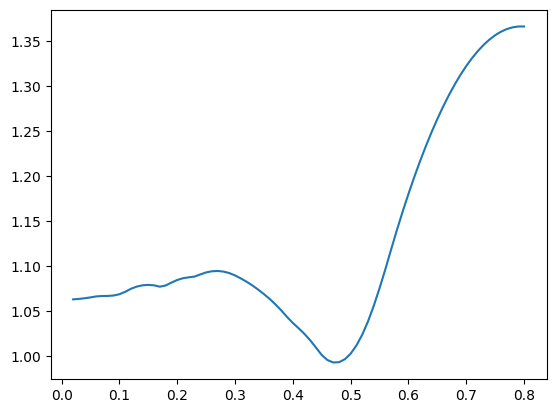

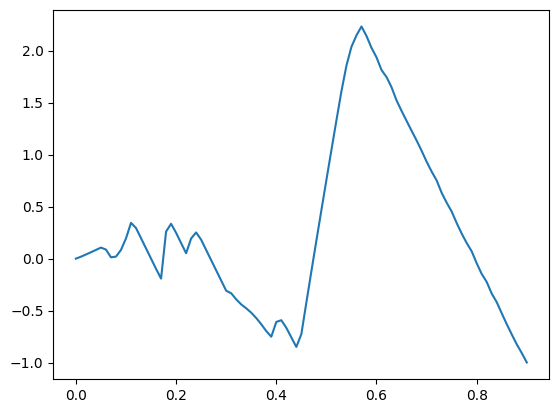

In [8]:
log = logger.FindLog(simulator.get_mutable_context()) #xyz vxvyvz
t = log.sample_times()
x = log.data()[2]   
xdot = log.data()[-1]

plt.figure()
plt.plot(t[2:-10], x[2:-10])
plt.figure()
plt.plot(t, xdot)
# plt.savefig(f"./logs/{time}plots.png")
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=71c969e2-d88b-4bfd-96cb-c4ea4f7f9122' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>